***E22CSEU1164 PRIYANSHU***

***USING DEEP LSTM FOR PREDICTING SOIL MOISTURE***

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 594ms/step - loss: 0.2399 - val_loss: 0.2837
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2212 - val_loss: 0.2655
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2149 - val_loss: 0.2492
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2088 - val_loss: 0.2328
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1854 - val_loss: 0.2160
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1767 - val_loss: 0.1981
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1589 - val_loss: 0.1789
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1500 - val_loss: 0.1587
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1361 - val_loss: 0.1375
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1276 - val_loss: 0.1151
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1116 - val_loss: 0.0922
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0950 - val_l

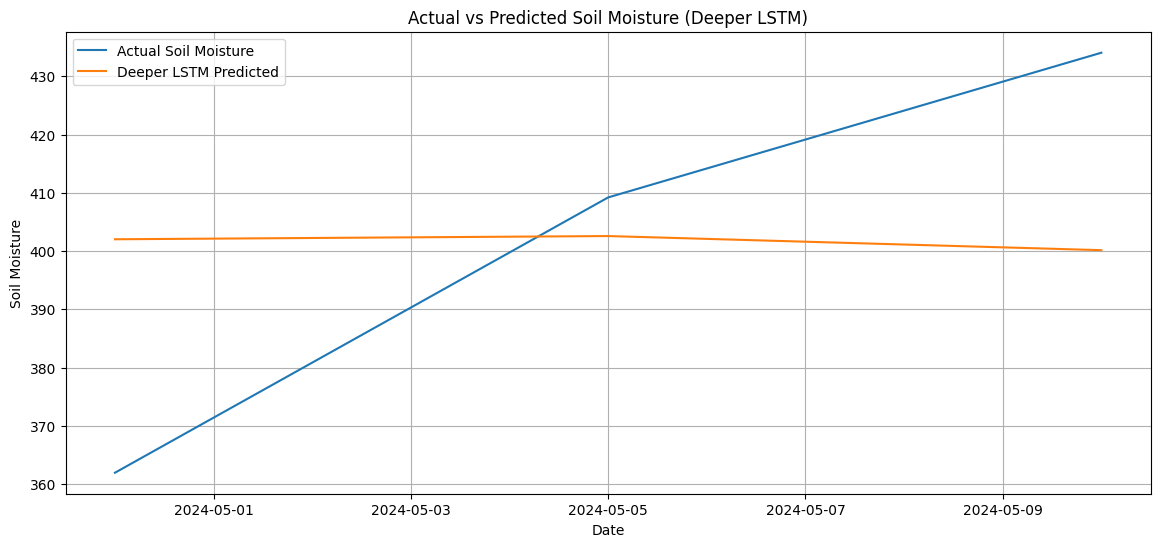

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Future 7-Day Soil Moisture Forecast (Deeper LSTM):
        Date  LSTM Soil Moisture Forecast
0 2024-05-11                   401.649872
1 2024-05-12                   400.969299
2 2024-05-13                   401.012909
3 2024-05-14                   408.497620
4 2024-05-15                   408.128845
5 2024-05-16                   403.250549
6 2024-05-17                   403.791748

Smart Irrigation Recommendations for next 7 days (Deeper LSTM):
        Date  LSTM Soil Moisture Forecast        Recommendation
0 2024-05-11                   401.649872  No Irrigation Needed
1 2024-05-12                   400.969299  No Irrigation Needed
2 2024-05-13                   401.012909  No Irrigation Needed
3 2024-05-14            

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt

df = pd.read_csv('/kaggle/input/project-time-series/Cleaned_Time_Series_Dataset.csv')

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

soil_df = df.groupby('Date')['Soil moisture'].mean().reset_index()

scaler = MinMaxScaler()
soil_df['Soil moisture scaled'] = scaler.fit_transform(soil_df[['Soil moisture']])
window_size = 5  

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(soil_df['Soil moisture scaled'].values, window_size)

train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

plt.figure(figsize=(14,6))
plt.plot(soil_df['Date'][train_size+window_size:], y_test_rescaled, label='Actual Soil Moisture')
plt.plot(soil_df['Date'][train_size+window_size:], y_pred_rescaled, label='Deeper LSTM Predicted')
plt.title('Actual vs Predicted Soil Moisture (Deeper LSTM)')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.grid(True)
plt.show()

last_sequence = soil_df['Soil moisture scaled'].values[-window_size:]
future_predictions = []

current_sequence = last_sequence.copy()

for _ in range(7):
    current_sequence_reshaped = current_sequence.reshape((1, window_size, 1))
    next_pred_scaled = model.predict(current_sequence_reshaped)[0][0]
    future_predictions.append(next_pred_scaled)
    current_sequence = np.append(current_sequence[1:], next_pred_scaled)

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_date = soil_df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1,8)]

future_forecast = pd.DataFrame({
    'Date': future_dates,
    'LSTM Soil Moisture Forecast': future_predictions_rescaled.flatten()
})

print("\nFuture 7-Day Soil Moisture Forecast (Deeper LSTM):")
print(future_forecast)

threshold = 300

recommendations = []
for val in future_forecast['LSTM Soil Moisture Forecast']:
    if val < threshold:
        recommendations.append('Irrigation Required')
    else:
        recommendations.append('No Irrigation Needed')

future_forecast['Recommendation'] = recommendations

print("\nSmart Irrigation Recommendations for next 7 days (Deeper LSTM):")
print(future_forecast)


In [ ]:

!pip install pmdarima
!pip install prophet

***USING ARIMA, SARIMA, PROPHET TO PREDICT SOIL MOISTURE*** 

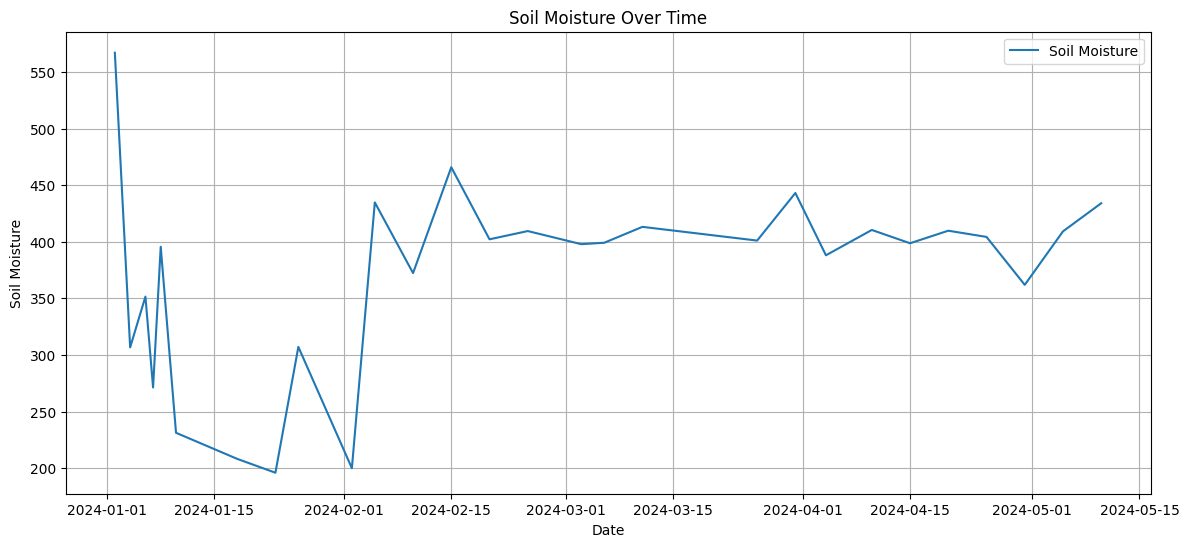

ADF Statistic: -1.6345734376079264
p-value: 0.4650977129500087
Series is Non-Stationary. Applying Differencing...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -137.067
Date:                Mon, 28 Apr 2025   AIC                            280.133
Time:                        10:19:34   BIC                            283.667
Sample:                             0   HQIC                           281.071
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9451      0.085    -11.124      0.000      -1.112      -0.779
ma.L1          0.

10:19:34 - cmdstanpy - INFO - Chain [1] start processing
10:19:34 - cmdstanpy - INFO - Chain [1] done processing



Performance Comparison Table:
     Model        MAE       RMSE
0    ARIMA  41.940424  46.044825
1   SARIMA  68.583505  71.459623
2  Prophet  36.937839  48.874246


10:19:35 - cmdstanpy - INFO - Chain [1] start processing
10:19:35 - cmdstanpy - INFO - Chain [1] done processing



Future 7-Day Soil Moisture Forecast:
         Date  ARIMA Forecast  SARIMA Forecast  Prophet Forecast
27 2024-05-11        4.087874       121.537432         27.278117
28 2024-05-12       -3.859909       -34.424728         25.270757
29 2024-05-13        3.644658        31.414188        119.057448
30 2024-05-14       -3.441410        64.326905         -7.908719
31 2024-05-15        3.249496       116.278570        -17.741046
32 2024-05-16       -3.068285       -16.244611        -19.255128
33 2024-05-17        2.897179       225.088902         37.488483


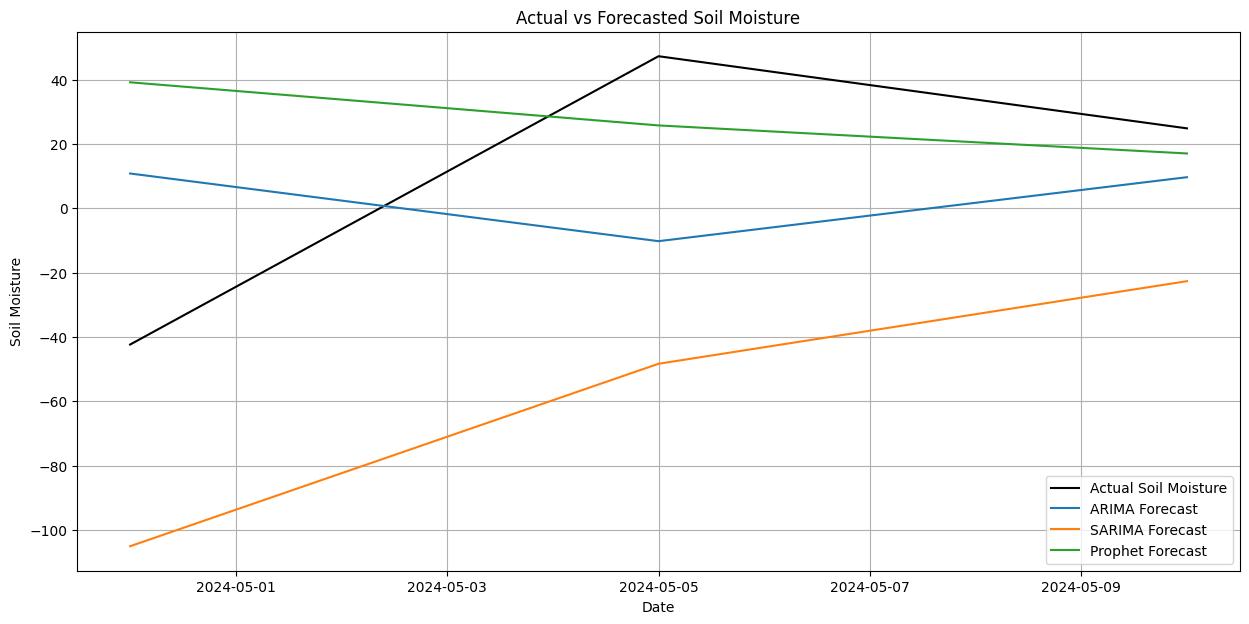

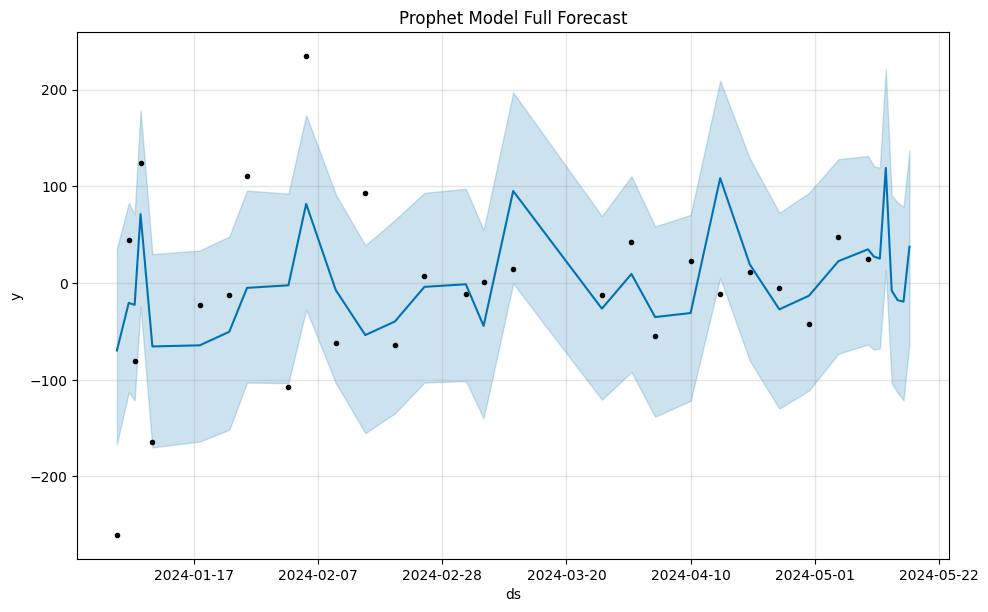


Smart Irrigation Recommendations for next 7 days:
         Date  ARIMA Forecast  SARIMA Forecast  Prophet Forecast  \
27 2024-05-11        4.087874       121.537432         27.278117   
28 2024-05-12       -3.859909       -34.424728         25.270757   
29 2024-05-13        3.644658        31.414188        119.057448   
30 2024-05-14       -3.441410        64.326905         -7.908719   
31 2024-05-15        3.249496       116.278570        -17.741046   
32 2024-05-16       -3.068285       -16.244611        -19.255128   
33 2024-05-17        2.897179       225.088902         37.488483   

         Recommendation  
27  Irrigation Required  
28  Irrigation Required  
29  Irrigation Required  
30  Irrigation Required  
31  Irrigation Required  
32  Irrigation Required  
33  Irrigation Required  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/project-time-series/Cleaned_Time_Series_Dataset.csv')

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

soil_df = df.groupby('Date')['Soil moisture'].mean().reset_index()

plt.figure(figsize=(14,6))
plt.plot(soil_df['Date'], soil_df['Soil moisture'], label='Soil Moisture')
plt.title('Soil Moisture Over Time')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.grid(True)
plt.legend()
plt.show()

adf_result = adfuller(soil_df['Soil moisture'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print("Series is Non-Stationary. Applying Differencing...")
    soil_df['Soil moisture'] = soil_df['Soil moisture'].diff()
    soil_df = soil_df.dropna()
else:
    print("Series is Stationary.")

train_size = int(len(soil_df) * 0.9)
train = soil_df.iloc[:train_size]
test = soil_df.iloc[train_size:]

model_arima = pm.auto_arima(train['Soil moisture'], seasonal=False, stepwise=True, suppress_warnings=True)
print(model_arima.summary())

n_periods = len(test)
forecast_arima, confint_arima = model_arima.predict(n_periods=n_periods, return_conf_int=True)

model_sarima = SARIMAX(train['Soil moisture'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = model_sarima.fit(disp=False)

forecast_sarima = sarima_result.forecast(steps=n_periods)

prophet_df = train.rename(columns={'Date': 'ds', 'Soil moisture': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=n_periods)
forecast_prophet = model_prophet.predict(future)
forecast_prophet_part = forecast_prophet.iloc[-n_periods:]['yhat'].values

actual = test['Soil moisture'].values

mae_arima = mean_absolute_error(actual, forecast_arima)
rmse_arima = sqrt(mean_squared_error(actual, forecast_arima))

mae_sarima = mean_absolute_error(actual, forecast_sarima)
rmse_sarima = sqrt(mean_squared_error(actual, forecast_sarima))

mae_prophet = mean_absolute_error(actual, forecast_prophet_part)
rmse_prophet = sqrt(mean_squared_error(actual, forecast_prophet_part))

results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'MAE': [mae_arima, mae_sarima, mae_prophet],
    'RMSE': [rmse_arima, rmse_sarima, rmse_prophet]
})

print("\nPerformance Comparison Table:")
print(results)

model_arima.fit(soil_df['Soil moisture'])
forecast_7_arima, _ = model_arima.predict(n_periods=7, return_conf_int=True)

full_sarima = SARIMAX(soil_df['Soil moisture'], order=(1,1,1), seasonal_order=(1,1,1,12))
full_sarima_result = full_sarima.fit(disp=False)
forecast_7_sarima = full_sarima_result.forecast(steps=7)

full_prophet_df = soil_df.rename(columns={'Date': 'ds', 'Soil moisture': 'y'})
model_prophet_full = Prophet()
model_prophet_full.fit(full_prophet_df)

future_full = model_prophet_full.make_future_dataframe(periods=7)
forecast_full = model_prophet_full.predict(future_full)
forecast_7_prophet = forecast_full.iloc[-7:][['ds', 'yhat']]

future_forecast = pd.DataFrame({
    'Date': forecast_7_prophet['ds'].values,
    'ARIMA Forecast': forecast_7_arima,
    'SARIMA Forecast': forecast_7_sarima.values,
    'Prophet Forecast': forecast_7_prophet['yhat'].values
})

print("\nFuture 7-Day Soil Moisture Forecast:")
print(future_forecast)

plt.figure(figsize=(15,7))
plt.plot(test['Date'], actual, label='Actual Soil Moisture', color='black')
plt.plot(test['Date'], forecast_arima, label='ARIMA Forecast')
plt.plot(test['Date'], forecast_sarima, label='SARIMA Forecast')
plt.plot(test['Date'], forecast_prophet_part, label='Prophet Forecast')
plt.title('Actual vs Forecasted Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.grid(True)
plt.show()

model_prophet_full.plot(forecast_full)
plt.title('Prophet Model Full Forecast')
plt.show()

threshold = 300

recommendations = []
for val in future_forecast['Prophet Forecast']:
    if val < threshold:
        recommendations.append('Irrigation Required')
    else:
        recommendations.append('No Irrigation Needed')

future_forecast['Recommendation'] = recommendations

print("\nSmart Irrigation Recommendations for next 7 days:")
print(future_forecast)


***USING VAR TO FORECAST EVAPOTRANSPIRATION***

Missing values before interpolation:
 Evapotranspiration     0
Temperature [_C]       0
Humidity [%]           0
Solar Radiation ghi    0
Wind Speed             0
dtype: int64
Missing values after interpolation:
 Evapotranspiration     0
Temperature [_C]       0
Humidity [%]           0
Solar Radiation ghi    0
Wind Speed             0
dtype: int64
ADF Test for Evapotranspiration:
  ADF Statistic: -5.105042124073912
  p-value: 1.3695385608428514e-05

ADF Test for Temperature [_C]:
  ADF Statistic: -9.445819542252849
  p-value: 4.758957930620863e-16

ADF Test for Humidity [%]:
  ADF Statistic: -12.39054664772063
  p-value: 4.800082722066756e-23

ADF Test for Solar Radiation ghi:
  ADF Statistic: -9.665807161517801
  p-value: 1.3162431200394052e-16

ADF Test for Wind Speed:
  ADF Statistic: -6.9756775507019135
  p-value: 8.441169105988183e-10

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------

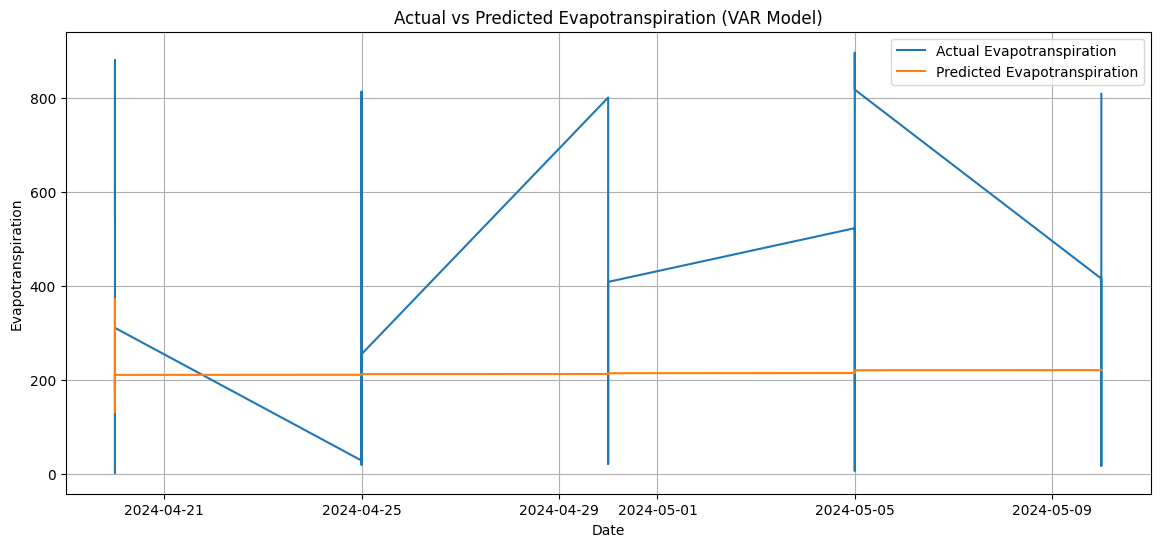

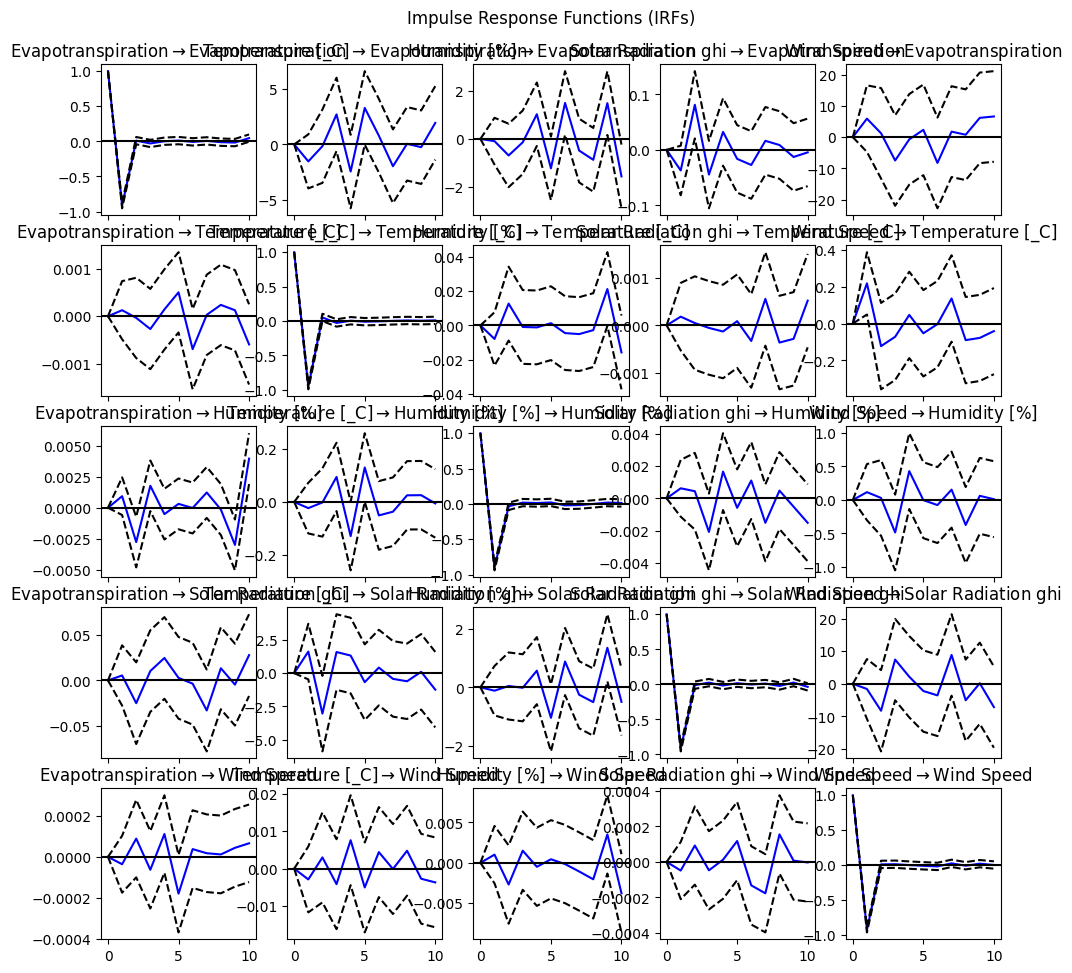

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

df = pd.read_csv('/kaggle/input/project-time-series/Cleaned_Time_Series_Dataset.csv')

df.columns = df.columns.str.strip() 

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

selected_cols = [
    'Evapotranspiration',
    'Temperature [_C]',
    'Humidity [%]',
    'Solar Radiation ghi',
    'Wind Speed'
]
data = df[selected_cols]

print("Missing values before interpolation:\n", data.isnull().sum())

data = data.interpolate(method='linear')

print("Missing values after interpolation:\n", data.isnull().sum())

def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test for {title}:')
    print('  ADF Statistic:', result[0])
    print('  p-value:', result[1])
    print()

for column in data.columns:
    adf_test(data[column], column)

data_diff = data.diff().dropna()

train_size = int(0.9 * len(data_diff))
train = data_diff.iloc[:train_size]
test = data_diff.iloc[train_size:]

model = VAR(train)

lag_order = model.select_order()
print(lag_order.summary())

selected_lag = lag_order.aic

var_model = model.fit(selected_lag)
print(var_model.summary())

n_forecast = len(test)
forecast_input = train.values[-selected_lag:]
forecast_result = var_model.forecast(y=forecast_input, steps=n_forecast)

forecast_df = pd.DataFrame(forecast_result, index=test.index, columns=train.columns)

last_observed = data.iloc[train_size-1]
forecast_cumsum = forecast_df.cumsum()
forecast_final = last_observed + forecast_cumsum

actual = data.iloc[train_size:]['Evapotranspiration']

actual = actual.iloc[1:] 

predicted = forecast_final['Evapotranspiration']

mae = mean_absolute_error(actual, predicted)
rmse = sqrt(mean_squared_error(actual, predicted))

print(f"\nEvaluation for Evapotranspiration Forecast:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


plt.figure(figsize=(14,6))
plt.plot(actual.index, actual, label='Actual Evapotranspiration')
plt.plot(predicted.index, predicted, label='Predicted Evapotranspiration')
plt.title('Actual vs Predicted Evapotranspiration (VAR Model)')
plt.xlabel('Date')
plt.ylabel('Evapotranspiration')
plt.legend()
plt.grid(True)
plt.show()

irf = var_model.irf(10)

irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (IRFs)')
plt.show()


***USING MULTIVARIATE LSTM FOR FORECASTING EVAPOTRANSPIRATION***

X shape: (2990, 10, 5), y shape: (2990,)
Training samples: 2392, Testing samples: 598
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1332 - val_loss: 0.0911
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0784 - val_loss: 0.0888
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0802 - val_loss: 0.0889
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0803 - val_loss: 0.0886
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0786 - val_loss: 0.0883
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0809 - val_loss: 0.0879
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0803 - val_loss: 0.0873
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0798 - val_loss: 0.0876
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0774 - val_loss: 0.0875
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0774 - val_loss: 0.0882
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0743 - val_loss: 0.0871
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0743 - val_l

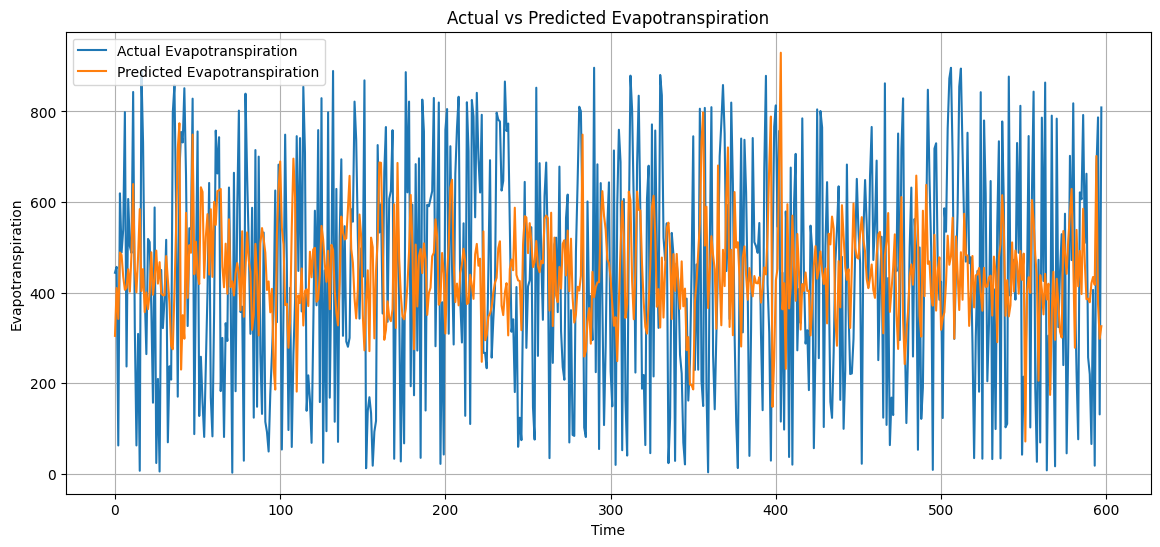

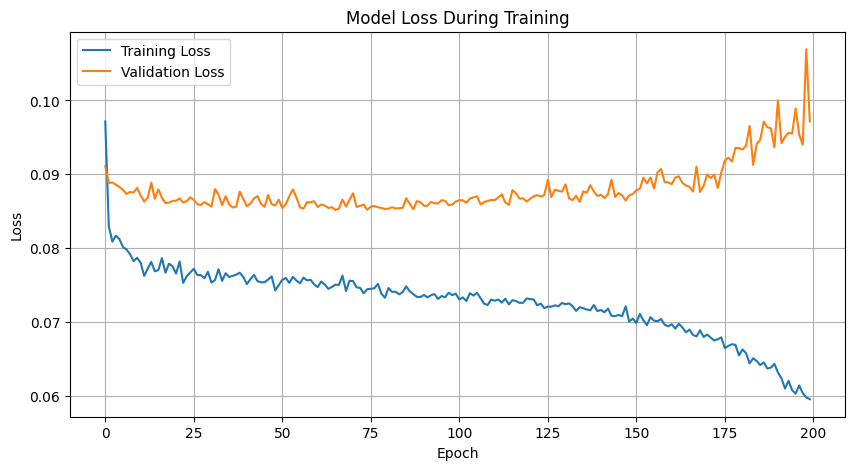

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = pd.read_csv('/kaggle/input/project-time-series/Cleaned_Time_Series_Dataset.csv')

df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

features = ['Temperature [_C]', 'Humidity [%]', 'Solar Radiation ghi', 'Wind Speed', 'Evapotranspiration']
df = df[features]

df = df.interpolate(method='linear')

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled, columns=features)

def create_sequences(data, target_col_idx, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, target_col_idx])
    return np.array(X), np.array(y)

window_size = 10
target_idx = features.index('Evapotranspiration')

X, y = create_sequences(scaled, target_idx, window_size)

print(f"X shape: {X.shape}, y shape: {y.shape}")

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test)

dummy_input = np.zeros((len(y_pred), scaled.shape[1]))
dummy_input[:, target_idx] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(dummy_input)[:, target_idx]

dummy_actual = np.zeros((len(y_test), scaled.shape[1]))
dummy_actual[:, target_idx] = y_test.flatten()
y_actual_inv = scaler.inverse_transform(dummy_actual)[:, target_idx]

mae = mean_absolute_error(y_actual_inv, y_pred_inv)
rmse = sqrt(mean_squared_error(y_actual_inv, y_pred_inv))

print(f"\nTest MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

plt.figure(figsize=(14,6))
plt.plot(y_actual_inv, label='Actual Evapotranspiration')
plt.plot(y_pred_inv, label='Predicted Evapotranspiration')
plt.title('Actual vs Predicted Evapotranspiration')
plt.xlabel('Time')
plt.ylabel('Evapotranspiration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
